# データの相互作用
大量のデータがある時に分析目的に対して何が寄与しているかであったり結果までの過程までは調べれば載っているため比較的容易に実装できる。一方で、それでは目的変数への寄与でしかなく説明変数間での作用が分かるわけではない。そこでベイジアンネットワークと有向グラフを使用することで相互作用を可視化することができる。

前半参考:https://qiita.com/JunJun100/items/541103e08a9ea6e23e68

後半参考:https://cpp-learning.com/causalnex/

#ベイジアンネットワーク
# ライブラリのインストール

In [ ]:
!pip install pgmpy==0.1.9

     |████████████████████████████████| 331 kB 4.0 MB/s 


# 使用するデータのマウント
基本的にPythonの初期設定のIDLEでライブラリをインストールすれば使用できるがJupyterNotebookでは使用できないことが多いため今回はGoogle colabを使用することを前提に実装する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ライブラリのインポート

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.inference import VariableElimination
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# データの読み込み

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/for_create_book/データ分析/各パラメータの相互作用/wine.csv", encoding="shift-jis")
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


# ヒストグラムの出力
データを分割するに当たって分割する個数を考慮してできるだけ個数が偏らない数に調節する。

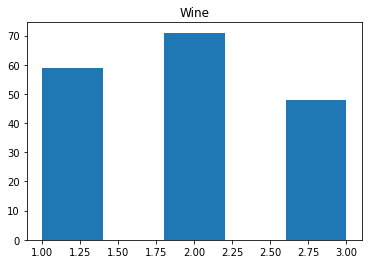

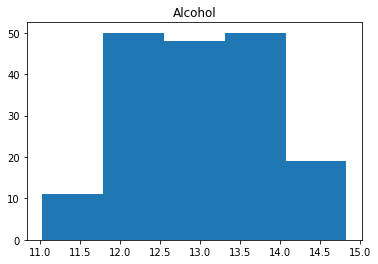

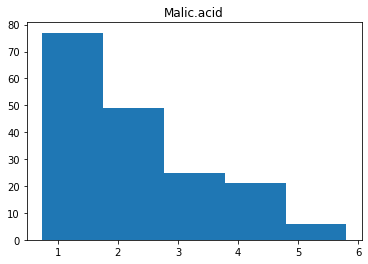

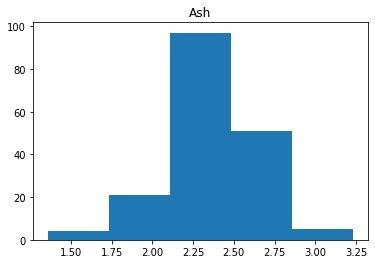

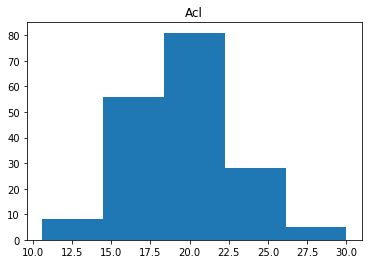

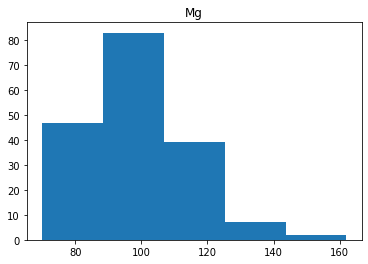

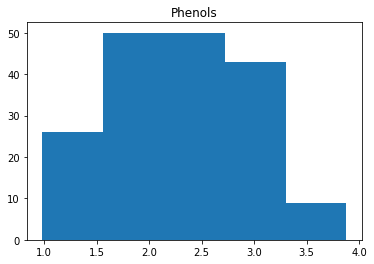

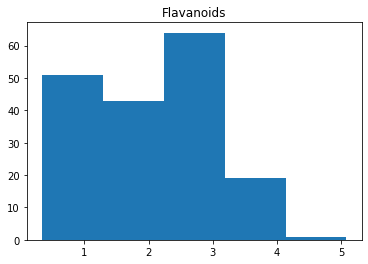

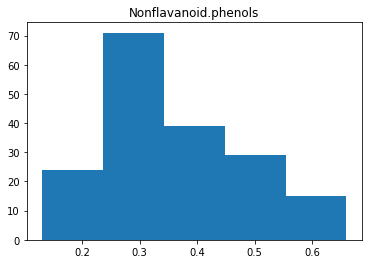

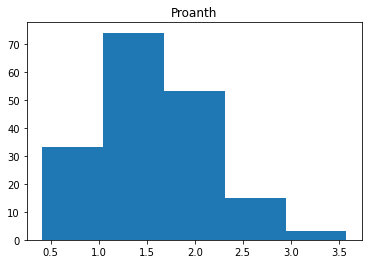

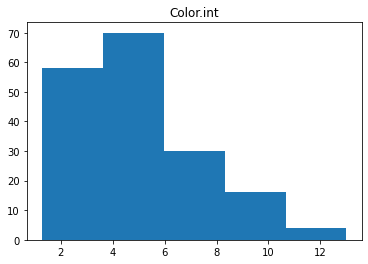

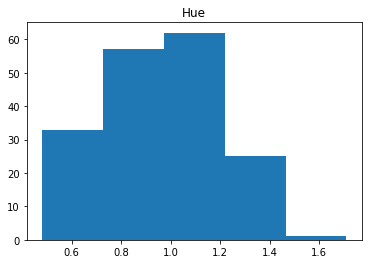

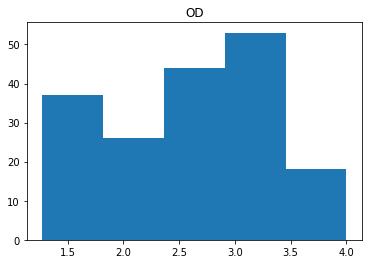

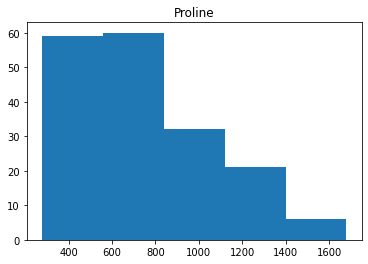

In [ ]:
columns = list(df.columns)
for col in columns:
  plt.hist(df[col].values, bins=5)
  plt.title(col)
  plt.show()

# データを比例尺度でカテゴリ化

In [ ]:
df_cate = df.copy()
for col in columns:
  if col != "Wine":
    df_cate[col] = pd.cut(df[col],5)
df_cate.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,"(12.55, 13.31]","(1.752, 2.764]","(2.108, 2.482]","(10.581, 14.48]","(88.4, 106.8]","(2.14, 2.72]","(2.236, 3.184]","(0.236, 0.342]","(1.044, 1.678]","(3.624, 5.968]","(0.972, 1.218]","(2.908, 3.454]","(838.8, 1119.2]"
1,1,"(12.55, 13.31]","(1.752, 2.764]","(2.482, 2.856]","(18.36, 22.24]","(88.4, 106.8]","(2.72, 3.3]","(3.184, 4.132]","(0.236, 0.342]","(2.312, 2.946]","(3.624, 5.968]","(0.972, 1.218]","(2.908, 3.454]","(1119.2, 1399.6]"
2,1,"(14.07, 14.83]","(1.752, 2.764]","(2.482, 2.856]","(14.48, 18.36]","(106.8, 125.2]","(3.3, 3.88]","(3.184, 4.132]","(0.236, 0.342]","(1.678, 2.312]","(5.968, 8.312]","(0.726, 0.972]","(2.908, 3.454]","(1399.6, 1680.0]"
3,1,"(12.55, 13.31]","(1.752, 2.764]","(2.856, 3.23]","(18.36, 22.24]","(106.8, 125.2]","(2.72, 3.3]","(2.236, 3.184]","(0.342, 0.448]","(1.678, 2.312]","(3.624, 5.968]","(0.972, 1.218]","(2.908, 3.454]","(558.4, 838.8]"
4,1,"(14.07, 14.83]","(1.752, 2.764]","(2.108, 2.482]","(14.48, 18.36]","(106.8, 125.2]","(2.72, 3.3]","(3.184, 4.132]","(0.236, 0.342]","(1.678, 2.312]","(5.968, 8.312]","(0.972, 1.218]","(2.362, 2.908]","(1399.6, 1680.0]"


# ベイジアンネットワークモデルの宣言と学習

In [ ]:
est = ConstraintBasedEstimator(df_cate)

In [ ]:
skel,separating_sets = est.estimate_skeleton(significance_level=0.01)
pdag = est.skeleton_to_pdag(skel, separating_sets)
model = est.pdag_to_dag(pdag)
DAG_model = BayesianModel(model.edges())

/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/CITests.py:89: UserWarning: Insufficient data for testing Wine _|_ Alcohol | ['Flavanoids']. At least 200 samples recommended, 178 present.
  5 * num_params, len(data)
/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/CITests.py:112: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  XZ_state_counts = XYZ_state_counts.sum(axis=1, level=Z)  # marginalize out Y
/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/CITests.py:89: UserWarning: Insufficient data for testing Wine _|_ Alcohol | ['Malic.acid']. At least 200 samples recommended, 178 present.
  5 * num_params, len(data)
/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/CITests.py:89: UserWarning: Insufficient data for testing Wine _|_ Alcohol | ['Proline']. At least 200 samples recommended, 178 present.
  

# 有向グラフの可視化

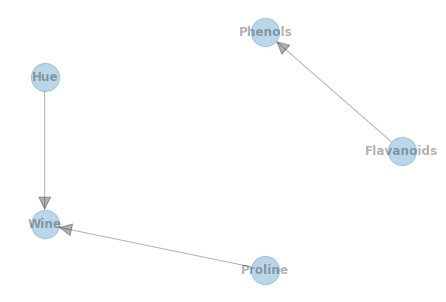

In [ ]:
nx.draw_circular(DAG_model, with_labels=True, arrowsize=30, node_size=800,alpha=0.3, font_weight='bold')
plt.show()

数値を5分割した場合、「Wine」の項目は「Hue」と「Proline」に影響されており「Phenols」は「Flavanoids」に影響されていることが分かる。

ただし、分割する数によって結果として出力されるグラフネットワークが異なることは注意点である。

# ベイジアンネットワークで条件付確率を表示

In [ ]:
DAG_model.fit(df)
cpds = DAG_model.get_cpds()
for cpd in cpds:
  print(cpd)

Output hidden; open in https://colab.research.google.com to view.

# 有向グラフ
# ライブラリのインストール

In [ ]:
!pip install causalnex

     |████████████████████████████████| 154 kB 5.1 MB/s 
     |████████████████████████████████| 1.9 MB 63.1 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 22.3 MB 69.7 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68726 sha256=f83a1ee35c97592daf4ab2744f719fa120d6fb8a00174a8b147413b99efac6dd
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Successfully uninstalled wrapt-1.13.3
  Attempting uninstall: pgmpy
    Found existing installation: pgmpy 0.1.9
    Uninstalling pgm

# ライブラリのインポート

In [ ]:
from causalnex.structure.notears import from_pandas

# DAG推定

In [ ]:
SM = from_pandas(df)

# 有向グラフの可視化

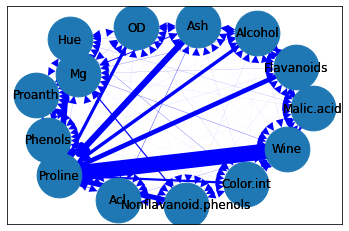

<Figure size 1152x648 with 0 Axes>

In [ ]:
pos = nx.spring_layout(SM,k=60)
#nx.draw_network_labels(SM)
edge_width = []
for (u, v, d) in SM.edges(data=True):
  edge_width.append(d['weight']*0.05)
nx.draw_networkx_labels(SM, pos)
nx.draw_networkx(SM, pos,node_size=2000, arrowsize=20, alpha=1.0, edge_color='b', width=edge_width)
plt.figure(figsize=(16, 9))
plt.show()